# Assingment #1

## Part2 Writing a renderer

Define a 3D-cube as a numpy array with 8 corners in 3D space centered on [0,0,0] and edge length 2, that is, 2 of the 8 diagonally-opposite corners have the coordinates [1,1,1] and [-1,-1,-1]. In order to show this on screen, we will also have to define the edges of the cube, that is, a Nx2-array that specifies which of the 8 corners are connected, like so:

$$\mathrm{edges}=[(0,1),(0,2),(1,3),\cdots]$$

Create this array, too. Let’s first show the cube on-screen “as is”, that is, without any explicit camera. For this, use the helper-function show_3d below – the structure of the function should also help you to figure out the edges-array...

Insert code that shows the cube using the function show_3d.

Now, let's start by moving our cube in front of the camera. For this, we will first do a transformation according to the extrinsic parameters of the camera, that is, translation and rotation.

Here is the general definition of a rotation matrix around a vector u=[ux,uy,uz] with ||u||=1:

$$R=\begin{bmatrix}
 cos\theta+u_x^2(1-cos\theta)& u_xu_y(1-cos\theta)-u_zsin\theta & u_xu_z(1-cos\theta)+u_ysin\theta\\ 
 u_yu_x(1-cos\theta)+u_zsin\theta& cos\theta+u_y^2(1-cos\theta) & u_yu_z(1-cos\theta)-u_xsin\theta\\ 
u_zu_x(1-cos\theta)-u_ysin\theta & u_zu_y(1-cos\theta)+u_xsin\theta & cos\theta+u_z^2(1-cos\theta)
\end{bmatrix}$$

Make a function for creating such a matrix, given a direction and an angle. Note that angles are in radians!

Next, create a translation matrix using another helper function that you need to code. This means that you have to use homogenous coordinates – check the lecture slides again, how the matrix will have to look. Also remember to augment the rotation matrices accordingly!!

Note that it is incredibly important to specify the order in which you rotate and in which you translate! Here, we rotate first around the x-axis (u=[1,0,0]), then around the y-axis, then around the z-axis, and then we translate.

Create a function get_extrinsic_matrix(position,orientation) that returns the final 4x4 extrinsic matrix that can convert homogenous coordinates.

Next, write a function to_homogenous(points) that turns an array of points into homogenous coordinates [simply add a 1 as another dimension!]. Write another function from_homogenous(points) that converts an array of homogenous coordinates into proper 3D or 2D coordinates [by dividing the first 2 or 3 coordinates by the third or fourth element – see lecture slides!]. Note, that these functions should work for both 3D and 2D input!!

Using

$$\mathrm{camera\_position}=[0,0,-3]$$
$$\mathrm{camera\_orientation}=[0,0.1,0]$$

insert the necessary transformations to transform the cube into camera coordinates using the transformation from get_extrinsic_matrix and show the result using show_3d. You will need to convert back and forth from homogenous coordinates to do this...

Next, let’s set up the intrinsic projection, including the projection matrix itself. Restrict the intrinsic matrix to only the focal length, such that

$$K=\begin{bmatrix}
f & 0 & s_x\\ 
0 & f & s_y\\ 
0 & 0 & 1
\end{bmatrix}$$

Make a function get_intrinsic_matrix(f,s) that creates the full intrinsic transformation including the projection matrix 3x4 P, so that we get a 3x4 matrix overall. Again, this uses homogenous coordinates.

Using

$$f=0.6$$
$$s=(0.5,0.5)$$

transform the camera coordinates into projected coordinates. In order to use the helper-function show_2D from below, you will need to multiply the resulting coordinates by the size of the pixel canvas in pixels. So, we want to show an image of 200x200 pixels, you need to multiply all points by 200.

Insert the final code that projects the cube into an image and plot the result using show_2d. Again, conversion between homogenous coordinates has to be used...

---

### Set up

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import atan, sin, cos
# you are only allowed to import numpy
# for further math calculations!!
import numpy as np
%matplotlib notebook

In [2]:
c = np.array([0, 0, 0])
L = 2
x1 = np.array([1, 1, 1])
x2 = np.array([-1, -1, -1])
u = np.array([1, 0, 0])
f = 0.6
s = np.array([0.5, 0.5])
camera_position = np.array([0, 0, -3])
camera_orientation = np.array([0, 0.1, 0])

$$\Pi = \underset{intrinsics}{\begin{bmatrix}
-fs_x & 0 & -x'_c\\ 
0 & -fs_y & y'_c\\ 
0 & 0 & 1
\end{bmatrix}}
\underset{projection}{\begin{bmatrix}
1 & 0 & 0 & 0\\ 
0 & 1 & 0 & 0\\ 
0 & 0 & 1 & 0
\end{bmatrix}}
\underset{rotation}{\begin{bmatrix}
R_{3\times 3} & 0_{3\times 1}\\ 
0_{1\times 3} & 1 
\end{bmatrix}}
\underset{translation}{\begin{bmatrix}
I_{3\times 3} & T_{3\times 1}\\ 
0_{1\times 3} & 1 
\end{bmatrix}}$$

In [3]:
def calc_R(u, orientation, position):
    """
    Get a rotation matrix 
    
    Arguments
    ---------
    position: a camera position in world coordinates 
    orientation: a orientation of a camera 
    u: general definition of a rotation matrix
    
    Returns
    -------
    ext: a matrix multiplication result of extrinsic matrix
    
    """
    orientation = orientation - position
    cos_t = np.dot(u, orientation.T)/(np.linalg.norm(u)*np.linalg.norm(orientation)) 
    sin_t = np.sqrt(1-cos_t**2)
    R = [
        [cos_t+(u[0]**2)*(1-cos_t), u[0]*u[1]*(1-cos_t)-u[2]*sin_t, u[0]*u[2]*(1-cos_t)+u[1]*sin_t],
        [u[1]*u[0]*(1-cos_t)+u[2]*sin_t, cos_t+(u[1]**2)*(1-cos_t), u[1]*u[2]*(1-cos_t)-u[0]*sin_t],
        [u[2]*u[0]*(1-cos_t)-u[1]*sin_t, u[2]*u[1]*(1-cos_t)+u[0]*sin_t, cos_t+(u[2]**2)*(1-cos_t)]
    ]
    return R

def calc_R2(u, orientation, position):
    """
    Get a rotation matrix 
    
    Arguments
    ---------
    position: a camera position in world coordinates 
    orientation: a orientation of a camera 
    u: general definition of a rotation matrix
    
    Returns
    -------
    ext: a matrix multiplication result of extrinsic matrix
    
    """
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(orientation[0]), -np.sin(orientation[0])],
        [0, np.sin(orientation[0]), np.cos(orientation[0])]
    ])
    Ry = np.array([
        [np.cos(orientation[1]), 0, np.sin(orientation[1])],
        [0, 1, 0],
        [-np.sin(orientation[1]), 0, np.cos(orientation[1])]
    ])
    Rz = np.array([
        [np.cos(orientation[2]), -np.sin(orientation[2]), 0],
        [np.sin(orientation[2]), np.cos(orientation[2]), 0],
        [0, 0, 1]
    ])
    R = Rx*Ry*Rz
    return R

def get_extrinsic_matrix(position, orientation, u):
    """
    Get a extrinsic matrix to rotate a camera direction
    
    Arguments
    ---------
    position: a camera position in world coordinates 
    orientation: a orientation of a camera 
    theta: a redian for a rotation matrix 
    
    Returns
    -------
    ext: a matrix multiplication result of extrinsic matrix
    
    """
    I = np.identity(3)
    C = np.array([-position])
    T = np.hstack([I, C.T])
    T = np.vstack([T, np.array([0,0,0,1])])
    R = calc_R2(u, orientation, position)
    R = np.hstack([R, np.zeros((3,1))])
    R = np.vstack([R, np.array([0, 0, 0, 1])])
    ext = np.dot(R, T)
    return ext

def to_homogenous(points):
    """
    Convert coordinates of a object into homogenous coordinates of a object. The object can be 2D or 3D.
    
    Argument
    --------
    points: coordinates of a object
    
    Return
    ------
    result: homogenous coordinates of a object
    
    """
    return np.hstack([points, np.ones((points.shape[0],1))])
    
def from_homogenous(points):
    """
    Convert homogenous coordinates of a object into origin coordinates of a object. The object can be 2D or 3D.
    
    Argument
    --------
    points: homogenous coordinates of a object

    Return
    ------
    result: origin coordinates of a object
    
    """
    return np.array(list(map(lambda x: x[:-1]/x[-1], points)))

def get_intrinsic_matrix(f: float = 0.6, s: tuple = (0.5, 0.5)):
    """
    Get intrinsic matrix of a camera
    
    Arguments
    ---------
    f: a focal length from a camera to a object (float, default = 0.6)
    s: principal points (tuple, default = (0.5, 0.5))
    
    Return
    ------
    intrinsic_matrix: a intrinsic matrix of a camera
    
    """
    K = [[f, 0, s[0]],
        [0, f, s[1]],
        [0, 0, 1]]
    return np.array(K)

def calc_v(points, position, orientation, u, f, s):
    ext = get_extrinsic_matrix(position, orientation, u)
    k = get_intrinsic_matrix(f, s)
    proj = np.hstack([np.identity(3), np.zeros((3,1))])
    P = np.dot(k, proj)
    P = np.dot(P, ext)
    rx = np.array(list(map(lambda y: np.dot(P, y), to_homogenous(points))))
    return rx

In [4]:
# these functions require non-homogenous coordinates
def show_3d(vertices, edges):
    """
    Show 3D image of a object
    
    Arguments
    ---------
    vertices: vertices of a object
    edges: edges of a object
    
    """
        
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]])
    ax.set_ylim(-5, 5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    plt.show()

def show_2d(vertices, edges, size):
    """
    Show 2D image of a object
    
    Arguments
    ---------
    vertices: vertices of a object (list)
    edges: edges of a object (list)
    size: maximum range of x and y axis (list, default = (1,1))
    
    """
    fig = plt.figure()
    ax = fig.gca()
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]])
    ax.set_xlim(0, size[0])
    ax.set_ylim(0, size[1])
    plt.show()

In [5]:
# define a cube vertices and edges
vertices = np.array([[1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1],
    [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1]])
vertices = np.array(vertices)
edges = []

for i in range(len(vertices)):
    edges.extend([[i, r] for r in range(i+1, len(vertices)) if np.sqrt(((vertices[i]-vertices[r])**2).sum())==L])

<IPython.core.display.Javascript object>


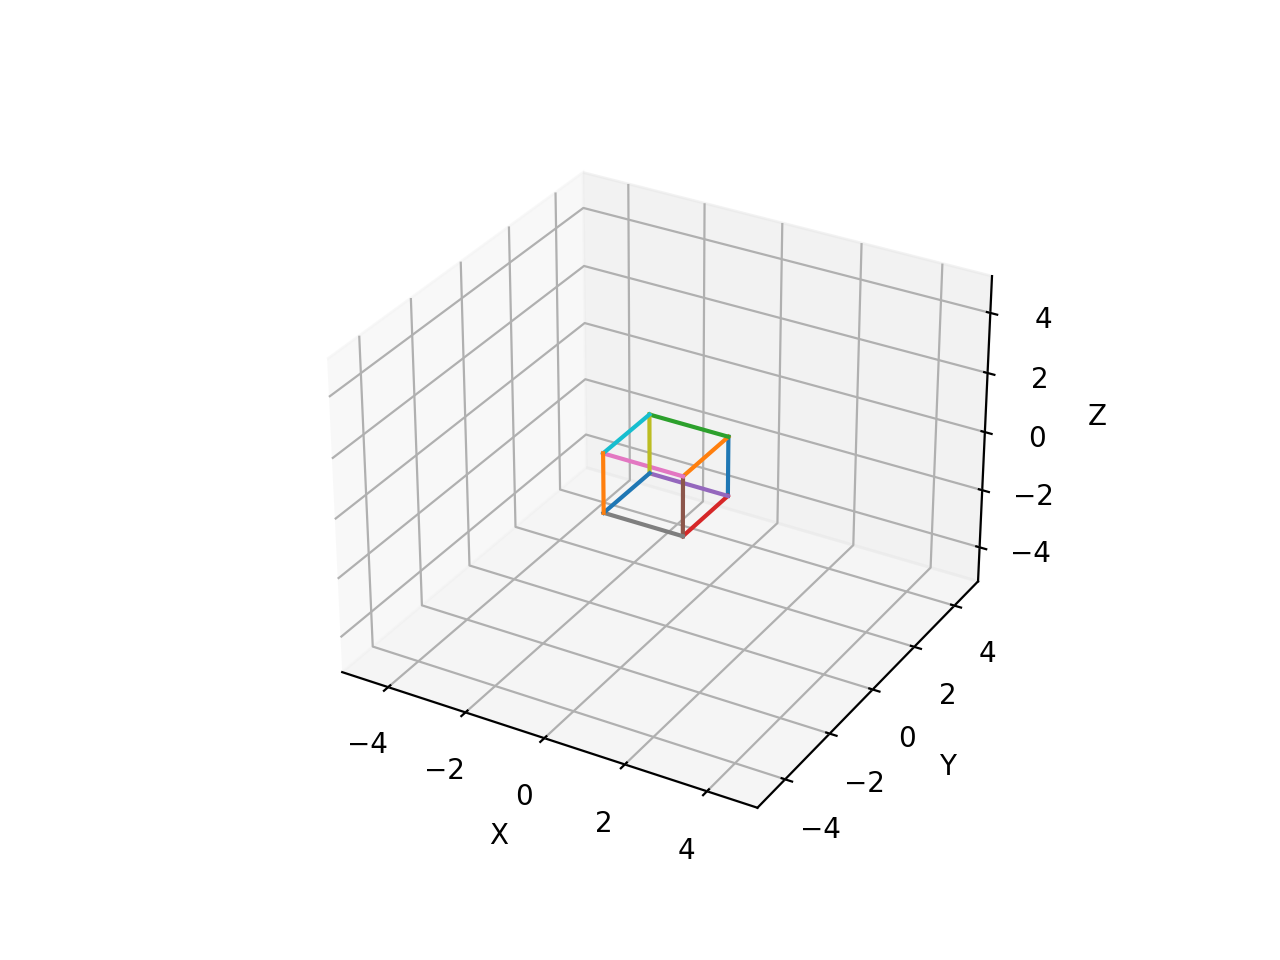

In [6]:
show_3d(vertices, edges)

In [7]:
ext_v = np.array(list(map(lambda y: np.dot(get_extrinsic_matrix(camera_position, camera_orientation, u), y), to_homogenous(vertices))))

In [8]:
repl_V = calc_v(vertices, camera_position, camera_orientation, u, f, s)
reduc_V = from_homogenous(repl_V)

### Visualization 3D

<IPython.core.display.Javascript object>


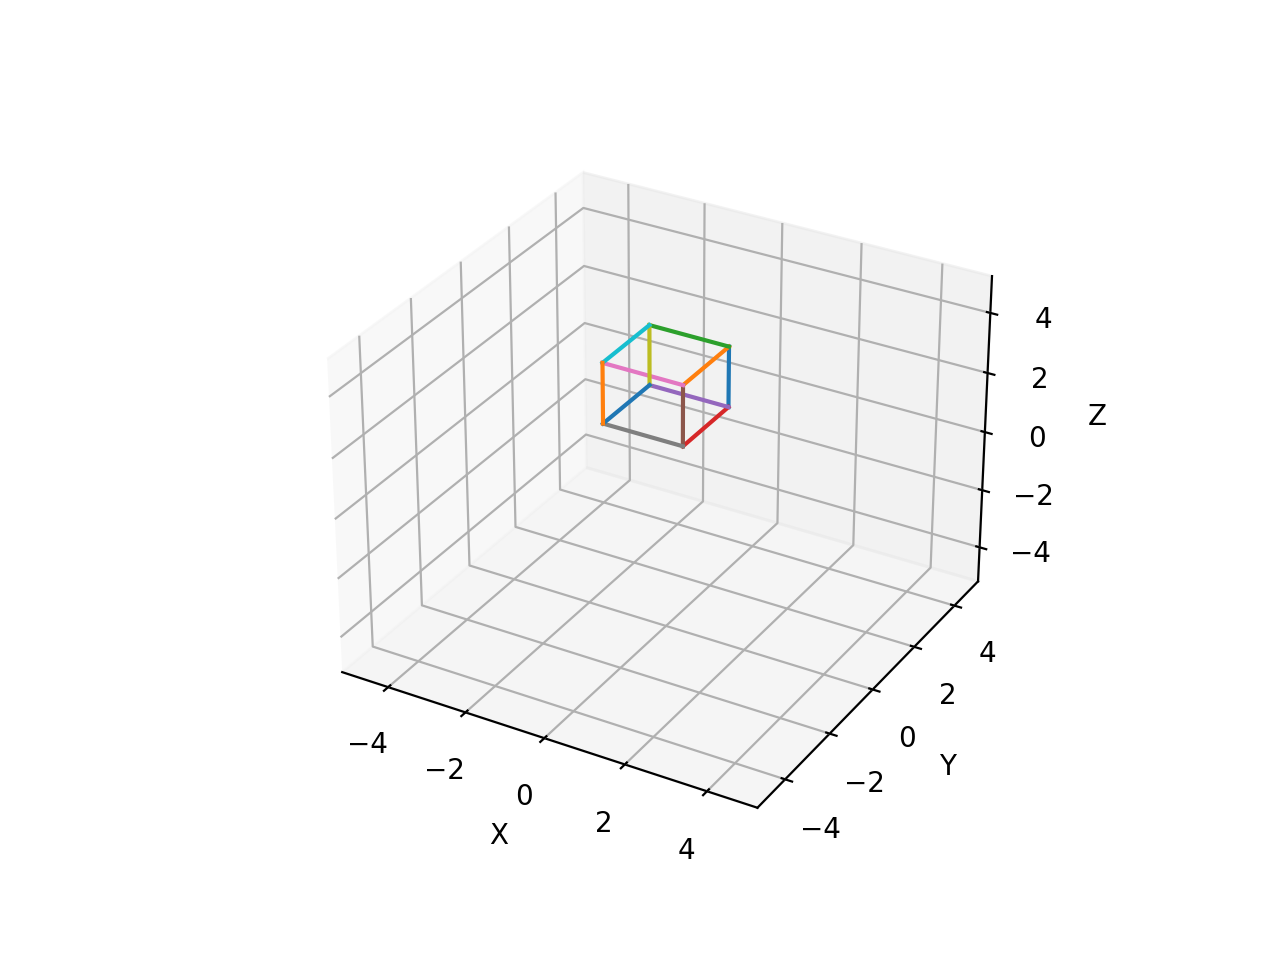

In [9]:
show_3d(ext_v, edges)

### Visualization 2D

<IPython.core.display.Javascript object>


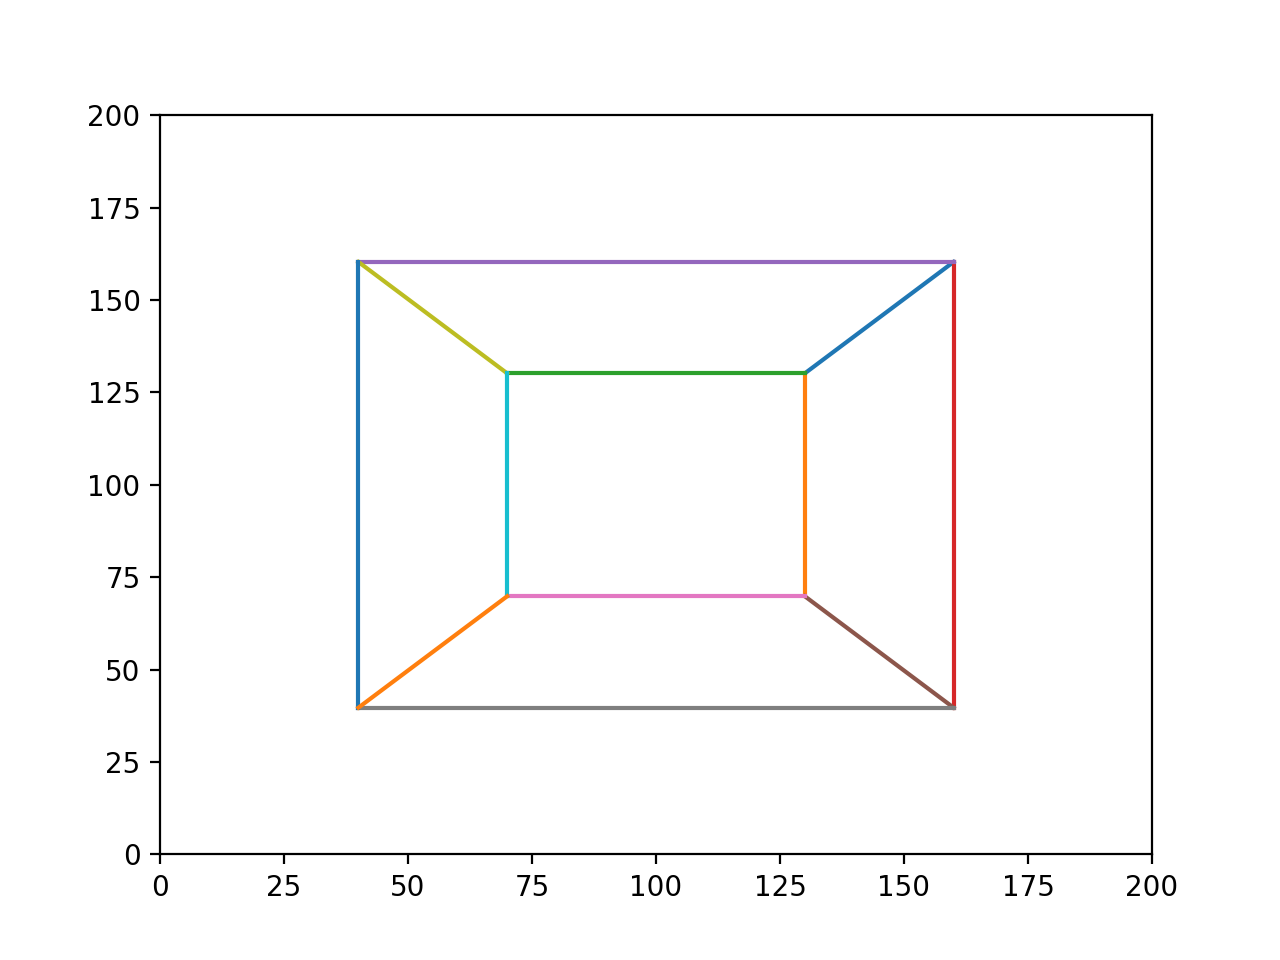

In [10]:
show_2d(reduc_V*200, edges, (200, 200))

# Bonus (20 points)

Insert code that shows an open tube of similar proportions [you will of course not be able to show the “round” tube with this code – so approximate the round base of the tube with a few lines]!

In [11]:
# We import ipywidgets for interactive tools
from ipywidgets import IntSlider, interact, FloatSlider

def draw_3d_polygon(n: int, r: float, h: float):
    """
    Draw a polygon cube
    
    Argument
    --------
    n: the number of vertices (float)
    r: radius (float)
    h: a height of a polygon cube (float)
    
    """
    center_degree = 360 / n
    
    vertices1 = np.array([(r * sin((center_degree * i) * np.pi / 180), h, r * cos((center_degree * i) * np.pi / 180)) for i in range(n)])
    vertices2 = np.array([(r * sin((center_degree * i) * np.pi / 180), -h, r * cos((center_degree * i) * np.pi / 180)) for i in range(n)])

    edges = [[i,i+1] for i in range(n)]
    edges[-1][1] = 0
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d') 
    for edge in edges:
        p1 = vertices1[edge[0]] 
        p2 = vertices1[edge[1]]
        
        p3 = vertices2[edge[0]] 
        p4 = vertices2[edge[1]]
        
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]], color='brown') 
        
        ax.plot([p3[0], p4[0]],
                [p3[1], p4[1]],
                [p3[2], p4[2]], color='brown')
    
        ax.plot([p1[0], p3[0]],
                [p1[1], p3[1]],
                [p1[2], p3[2]], color='brown') 
            
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5) 
    ax.set_zlim(-5, 5) 
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.set_zlabel('z')

In [12]:
%matplotlib inline
r = FloatSlider(value=1, min=1, max=10, step=0.1)
h = FloatSlider(value=1, min=1, max=10, step=0.1)
n = IntSlider(value=3, min=3, max=100, step=1)
interact(draw_3d_polygon, n=n, h=h, r=r)

interactive(children=(IntSlider(value=3, description='n', min=3), FloatSlider(value=1.0, description='r', max=…

<function __main__.draw_3d_polygon(n:int, r:float, h:float)>

---